In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Base path where client datasets are stored
client_base = r"C:\Users\karin\Documents\Federated_learning\clients"

# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(20),                     # rotation range 20 degrees
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),                         # width and height shift 20%
        shear=20,                                     # shear 20 degrees
        fill=0                                        # fill empty pixels with black
    ),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.2)),  # zoom range ~20%
    transforms.RandomHorizontalFlip(p=0.5),           # horizontal flip
    transforms.ToTensor()
])

# For validation/testing (no augmentation, only resize and tensor)
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create DataLoaders for each client
client_loaders = {}
batch_size = 16

for client in os.listdir(client_base):
    client_path = os.path.join(client_base, client, "Training")
    if not os.path.isdir(client_path):
        continue

    dataset = datasets.ImageFolder(client_path, transform=train_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    client_loaders[client] = loader

print("DataLoaders with augmentation created for clients:", list(client_loaders.keys()))


DataLoaders with augmentation created for clients: ['client1', 'client2', 'client3', 'client4']


In [9]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pretrained ResNet (without final classification layer)
resnet = models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]  # remove final FC layer
feature_extractor = nn.Sequential(*modules).to(device)
feature_extractor.eval()  # set to eval mode

# Example: extract features for a batch
for client, loader in client_loaders.items():
    for images, labels in loader:
        images = images.to(device)
        with torch.no_grad():
            features = feature_extractor(images)  # shape: [batch_size, 512, 1, 1]
            features = features.view(features.size(0), -1)  # flatten to [batch_size, 512]


In [10]:
client_features_dict = {}

for client, loader in client_loaders.items():
    all_features = []
    all_labels = []
    
    for images, labels in loader:
        images = images.to(device)
        with torch.no_grad():
            features = feature_extractor(images)           # [batch_size, 512, 1, 1]
            features = features.view(features.size(0), -1) # flatten to [batch_size, 512]
        
        all_features.append(features.cpu())  # move to CPU and store
        all_labels.append(labels)            # labels are already CPU tensors

    # Stack all batches to one tensor per client
    client_features_dict[client] = {
        "features": torch.cat(all_features, dim=0),  # [total_images, 512]
        "labels": torch.cat(all_labels, dim=0)       # [total_images]
    }

print("Feature extraction complete. Example shapes:")
for client, data in client_features_dict.items():
    print(client, data["features"].shape, data["labels"].shape)


Feature extraction complete. Example shapes:
client1 torch.Size([1000, 512]) torch.Size([1000])
client2 torch.Size([400, 512]) torch.Size([400])
client3 torch.Size([200, 512]) torch.Size([200])
client4 torch.Size([50, 512]) torch.Size([50])


In [11]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import numpy as np

# -----------------------------
# Determine fixed PCA dimension
# -----------------------------
min_samples = min([client_features_dict[c]['features'].shape[0] for c in client_features_dict])
fixed_n_components = min(50, min_samples)  # adjust 50 or lower if some client has very few images
print("Fixed PCA components:", fixed_n_components)

# -----------------------------
# Apply PCA per client
# -----------------------------
client_reduced_features = {}
for client in client_features_dict:
    X = client_features_dict[client]['features'].numpy()
    y = client_features_dict[client]['labels'].numpy()
    
    pca = PCA(n_components=fixed_n_components)
    X_reduced = pca.fit_transform(X)
    
    client_reduced_features[client] = {
        "features": X_reduced,
        "labels": y
    }
    
    print(client, "reduced features shape:", X_reduced.shape)

# -----------------------------
# Train Test Split
# -----------------------------

from sklearn.model_selection import train_test_split

client_train_data = {}
client_val_data = {}

for client in client_reduced_features:
    X = client_reduced_features[client]["features"]
    y = client_reduced_features[client]["labels"]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    client_train_data[client] = {"features": X_train, "labels": y_train}
    client_val_data[client] = {"features": X_val, "labels": y_val}

Fixed PCA components: 50
client1 reduced features shape: (1000, 50)
client2 reduced features shape: (400, 50)
client3 reduced features shape: (200, 50)
client4 reduced features shape: (50, 50)



--- Round 1 --- μ = 0.00100
Round 1: Avg Validation Accuracy = 0.2300
Client client1 - Local Loss: 1.3363, Accuracy: 0.2138
Client client2 - Local Loss: 1.3082, Accuracy: 0.2156
Client client3 - Local Loss: 1.3421, Accuracy: 0.4375
Client client4 - Local Loss: 1.3531, Accuracy: 0.2750
New best model saved with accuracy: 0.2300

--- Round 2 --- μ = 0.00133
Round 2: Avg Validation Accuracy = 0.2512
Client client1 - Local Loss: 1.3306, Accuracy: 0.2225
Client client2 - Local Loss: 1.3030, Accuracy: 0.2156
Client client3 - Local Loss: 1.3341, Accuracy: 0.4375
Client client4 - Local Loss: 1.3409, Accuracy: 0.3000
New best model saved with accuracy: 0.2512

--- Round 3 --- μ = 0.00166
Round 3: Avg Validation Accuracy = 0.2713
Client client1 - Local Loss: 1.3251, Accuracy: 0.2288
Client client2 - Local Loss: 1.2981, Accuracy: 0.2281
Client client3 - Local Loss: 1.3265, Accuracy: 0.4437
Client client4 - Local Loss: 1.3291, Accuracy: 0.3250
New best model saved with accuracy: 0.2713

--- Round

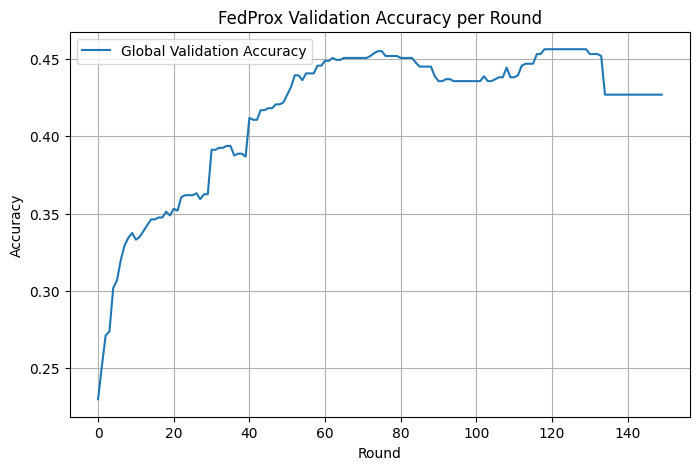


=== Comparison: Local vs Global FedProx ===
client1: Local=0.1440, Global=0.4330, Δ=+0.2890
client2: Local=0.3000, Global=0.4775, Δ=+0.1775
client3: Local=0.2150, Global=0.4750, Δ=+0.2600
client4: Local=0.3800, Global=0.7400, Δ=+0.3600


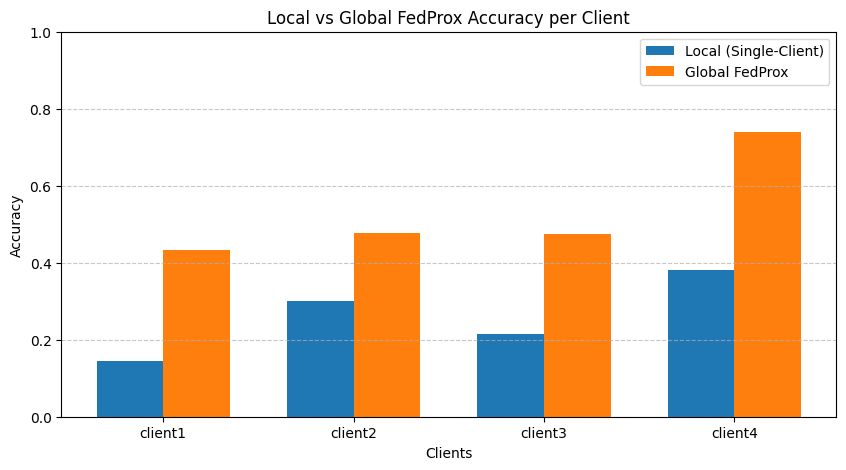

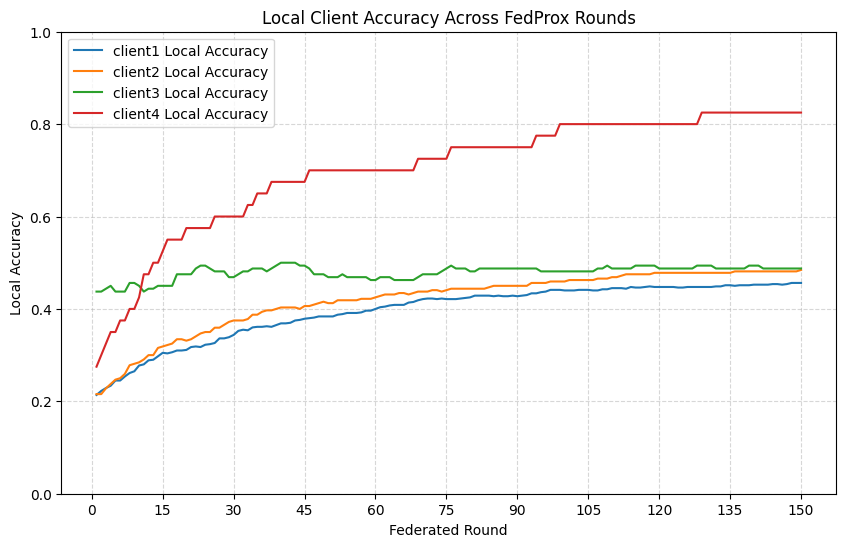


Global Evaluation (all clients combined) - Loss: 1.2178, Accuracy: 0.4582

Classification Report:
              precision    recall  f1-score   support

      glioma       0.73      0.43      0.54       760
  meningioma       0.33      0.44      0.37       265
     notumor       0.34      0.55      0.42       235
   pituitary       0.39      0.46      0.43       390

    accuracy                           0.46      1650
   macro avg       0.45      0.47      0.44      1650
weighted avg       0.53      0.46      0.47      1650



In [14]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Define MLP
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=fixed_n_components, num_classes=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -----------------------------
# FedAvg aggregation
# -----------------------------
def fed_avg(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = sum([w[key] for w in weights_list]) / len(weights_list)
    return avg_weights

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X, y):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(X)
        loss = nn.CrossEntropyLoss()(outputs, y)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == y).float().mean().item()
    return loss.item(), acc

# -----------------------------
# Federated Learning Parameters
# -----------------------------
num_rounds = 150
local_epochs = 3
learning_rate = 0.01

# Dynamic FedProx μ schedule
mu_start = 0.001
mu_end = 0.05

# Initialize global model
global_model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
global_weights = global_model.state_dict()

global_history = []
best_acc = 0.0

# -----------------------------
# Class weights per client (for imbalance)
# -----------------------------
client_class_weights = {}
num_classes = 4
for client in client_train_data:
    labels = client_train_data[client]["labels"]
    counts = np.bincount(labels, minlength=num_classes)
    weights = 1.0 / (counts + 1e-6)  # avoid division by zero
    weights = weights / weights.sum() * num_classes  # normalize
    client_class_weights[client] = torch.tensor(weights, dtype=torch.float32).to(device)

# -----------------------------
# Federated Training Loop with FedProx + Local Performance Tracking
# -----------------------------
local_performance_history = []

for round in range(num_rounds):
    mu = mu_start + (mu_end - mu_start) * (round / (num_rounds - 1))
    local_weights = []
    round_local_metrics = {}
    print(f"\n--- Round {round+1} --- μ = {mu:.5f}")

# --- Local Training per client ---
    for client in client_train_data:
        X_train = torch.tensor(client_train_data[client]['features'], dtype=torch.float32).to(device)
        y_train = torch.tensor(client_train_data[client]['labels'], dtype=torch.long).to(device)

        model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
        model.load_state_dict(copy.deepcopy(global_weights))
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(weight=client_class_weights[client])

        model.train()
        for epoch in range(local_epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            # --- FedProx proximal term ---
            prox_reg = 0.0
            for w, w_global in zip(model.parameters(), global_model.parameters()):
                prox_reg += ((w - w_global).norm(2))**2
            loss += (mu / 2) * prox_reg

            loss.backward()
            optimizer.step()

        local_weights.append(copy.deepcopy(model.state_dict()))

        # --- Evaluate local model performance ---
        model.eval()
        with torch.no_grad():
            outputs = model(X_train)
            _, preds = torch.max(outputs, 1)
            acc = (preds == y_train).float().mean().item()
            loss_val = criterion(outputs, y_train).item()
        round_local_metrics[client] = {"loss": loss_val, "accuracy": acc}

    local_performance_history.append(round_local_metrics)

    # --- FedAvg aggregation ---
    global_weights = fed_avg(local_weights)
    global_model.load_state_dict(global_weights)

    # --- Global Evaluation on clients' validation sets ---
    val_accuracies = []
    for client in client_val_data:
        X_val = client_val_data[client]['features']
        y_val = client_val_data[client]['labels']
        _, acc = evaluate_model(global_model, X_val, y_val)
        val_accuracies.append(acc)
    
    avg_val_acc = np.mean(val_accuracies)
    global_history.append(avg_val_acc)
    print(f"Round {round+1}: Avg Validation Accuracy = {avg_val_acc:.4f}")

    # Print local performance per client
    for client, metrics in round_local_metrics.items():
        print(f"Client {client} - Local Loss: {metrics['loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}")

    # Save the best global model
    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        torch.save(global_model.state_dict(), "best_global_model.pth")
        print(f"New best model saved with accuracy: {best_acc:.4f}")

# -----------------------------
# Plot Global Accuracy History
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(global_history, label="Global Validation Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("FedProx Validation Accuracy per Round")
plt.legend()
plt.grid(True)
plt.show()

# --- Compare local (single-client) vs global FedProx ---
local_results = {}
for client in client_reduced_features:
    X = torch.tensor(client_reduced_features[client]['features'], dtype=torch.float32).to(device)
    y = torch.tensor(client_reduced_features[client]['labels'], dtype=torch.long).to(device)

    # Train local model on client data only
    model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(weight=client_class_weights[client])
    model.train()
    for epoch in range(local_epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    # Evaluate local model
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        acc = (preds == y).float().mean().item()
        loss_val = criterion(outputs, y).item()
    local_results[client] = {"loss": loss_val, "accuracy": acc}

# Evaluate global FedProx model per client
global_results = {}
global_model.eval()
for client in client_reduced_features:
    X = torch.tensor(client_reduced_features[client]['features'], dtype=torch.float32).to(device)
    y = torch.tensor(client_reduced_features[client]['labels'], dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = global_model(X)
        _, preds = torch.max(outputs, 1)
        acc = (preds == y).float().mean().item()
        loss_val = nn.CrossEntropyLoss()(outputs, y).item()
    global_results[client] = {"loss": loss_val, "accuracy": acc}

# Print comparison
print("\n=== Comparison: Local vs Global FedProx ===")
for client in client_reduced_features:
    local_acc = local_results[client]["accuracy"]
    global_acc = global_results[client]["accuracy"]
    print(f"{client}: Local={local_acc:.4f}, Global={global_acc:.4f}, Δ={global_acc - local_acc:+.4f}")
import numpy as np
clients = list(client_reduced_features.keys())
local_accs = [local_results[c]['accuracy'] for c in clients]
global_accs = [global_results[c]['accuracy'] for c in clients]

x = np.arange(len(clients))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, local_accs, width, label='Local (Single-Client)')
plt.bar(x + width/2, global_accs, width, label='Global FedProx')
plt.ylabel('Accuracy')
plt.xlabel('Clients')
plt.title('Local vs Global FedProx Accuracy per Client')
plt.xticks(x, clients)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(10,6))
for client in clients:
    accs = [local_performance_history[r][client]['accuracy'] for r in range(num_rounds)]
    plt.plot(range(1, num_rounds+1), accs, label=f'{client} Local Accuracy')
plt.xlabel('Federated Round')
plt.ylabel('Local Accuracy')
plt.title('Local Client Accuracy Across FedProx Rounds')
plt.xticks(range(0, num_rounds+1, max(1,num_rounds//10)))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


# -----------------------------
# Final Evaluation Across All Clients
# -----------------------------
X_all = np.vstack([client_reduced_features[c]['features'] for c in client_reduced_features])
y_all = np.hstack([client_reduced_features[c]['labels'] for c in client_reduced_features])

X_all_t = torch.tensor(X_all, dtype=torch.float32).to(device)
y_all_t = torch.tensor(y_all, dtype=torch.long).to(device)

global_model.eval()
with torch.no_grad():
    outputs = global_model(X_all_t)
    _, preds = torch.max(outputs, 1)
    loss_all = nn.CrossEntropyLoss()(outputs, y_all_t).item()
    acc_all = (preds == y_all_t).float().mean().item()

print(f"\nGlobal Evaluation (all clients combined) - Loss: {loss_all:.4f}, Accuracy: {acc_all:.4f}")

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_all_t.cpu().numpy(), preds.cpu().numpy(),
                            target_names=['glioma','meningioma','notumor','pituitary']))